In [1]:
# Step 1.1: Generate Synthetic Loan Application Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Load the synthetic loan data into a DataFrame
data = pd.read_csv('synthetic_loan_data.csv')

# Inspect the first few rows of the dataset
data.head()

,credit_score,income,loan_amount,loan_term,employment_status,property_value,loan_purpose,down_payment,residence_type,monthly_debt,fraud
0,816,57631.52,172141.74,10,employed,265196.65,purchase,47113.37,primary,1799.959653,0
1,757,44960.52,219495.84,20,employed,336570.38,refinance,42114.43,secondary,446.127538,0
2,847,32194.92,198853.20,30,unemployed,253821.41,home_improvement,19185.19,primary,993.858253,0
3,651,61168.91,224470.32,10,self-employed,198034.10,home_improvement,25108.19,investment,630.112492,0
4,657,41055.58,172539.75,30,unemployed,286421.59,home_improvement,17573.86,primary,469.844642,0


In [2]:
# Analysis of the dataset

# Display the shape of the dataset
print("\nShape of the dataset:")
print(data.shape)

# Display the data types of each column
print("\nData types of each column:")
print(data.dtypes)

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())



Shape of the dataset:
(10000, 11)

Data types of each column:
credit_score           int64
income               float64
loan_amount          float64
loan_term              int64
employment_status     object
property_value       float64
loan_purpose          object
down_payment         float64
residence_type        object
monthly_debt         float64
fraud                  int64
dtype: object

Missing values in each column:
credit_score         0
income               0
loan_amount          0
loan_term            0
employment_status    0
property_value       0
loan_purpose         0
down_payment         0
residence_type       0
monthly_debt         0
fraud                0
dtype: int64


In [3]:
# Generate summary statistics
print("\nSummary statistics:")
data.describe()



Summary statistics:


,credit_score,income,loan_amount,loan_term,property_value,down_payment,monthly_debt,fraud
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,712.93090,53630.390862,200126.879791,20.054500,290047.970288,29228.632050,1013.384732,0.050000
std,89.76815,16336.143292,31663.806511,7.046949,68831.272080,11941.151689,557.780515,0.217956
min,300.00000,-11743.230000,72498.360000,10.000000,38750.680000,15.660000,-362.124208,0.000000
25%,654.00000,43302.862500,179041.470000,15.000000,243655.235000,19036.577500,558.581448,0.000000
50%,718.00000,54255.980000,200220.235000,20.000000,289451.795000,29081.075000,945.154075,0.000000
75%,782.00000,64510.015000,221622.325000,25.000000,335948.452500,39518.862500,1392.699030,0.000000
max,849.00000,114388.900000,354685.230000,30.000000,558939.230000,49995.970000,3515.727417,1.000000


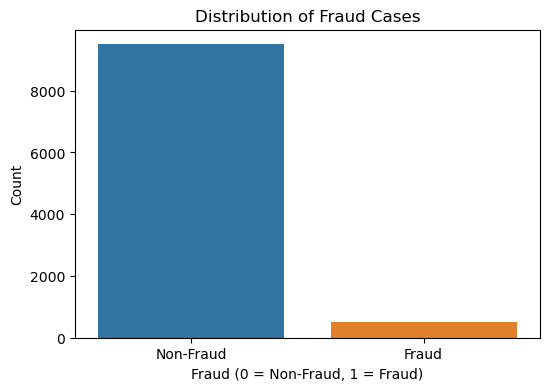

In [4]:
# Visualize the distribution of fraud cases
plt.figure(figsize=(6, 4))
sns.countplot(x='fraud', data=data)
plt.title('Distribution of Fraud Cases')
plt.xlabel('Fraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()


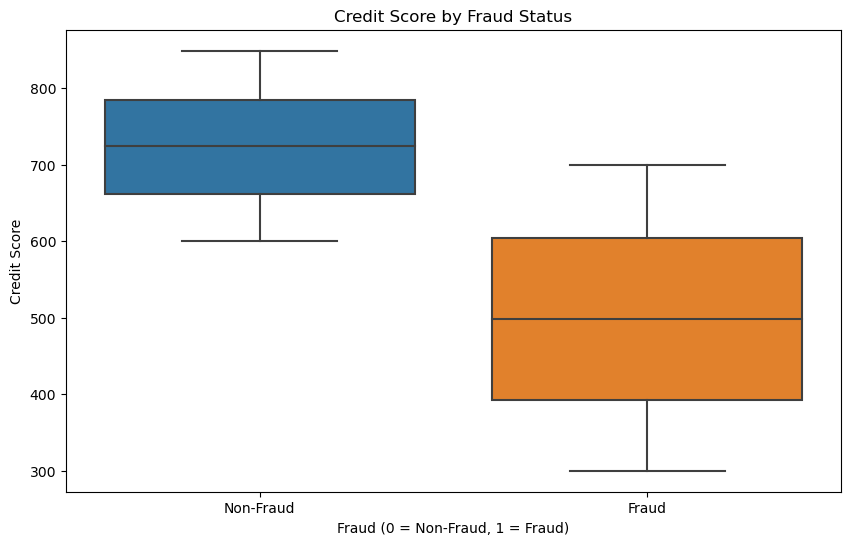

In [5]:
# Visualize the relationship between credit score and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraud', y='credit_score', data=data)
plt.title('Credit Score by Fraud Status')
plt.xlabel('Fraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Credit Score')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()


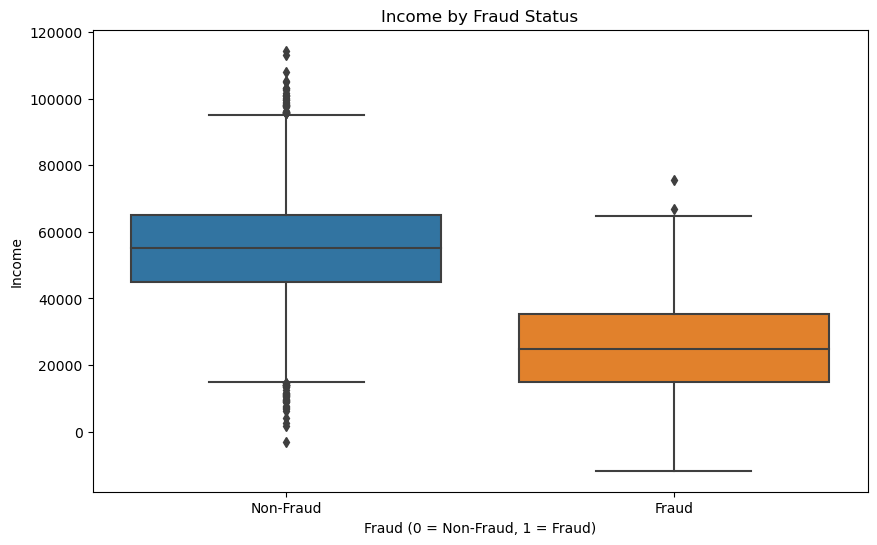

In [6]:
# Visualize income distribution by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraud', y='income', data=data)
plt.title('Income by Fraud Status')
plt.xlabel('Fraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Income')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()


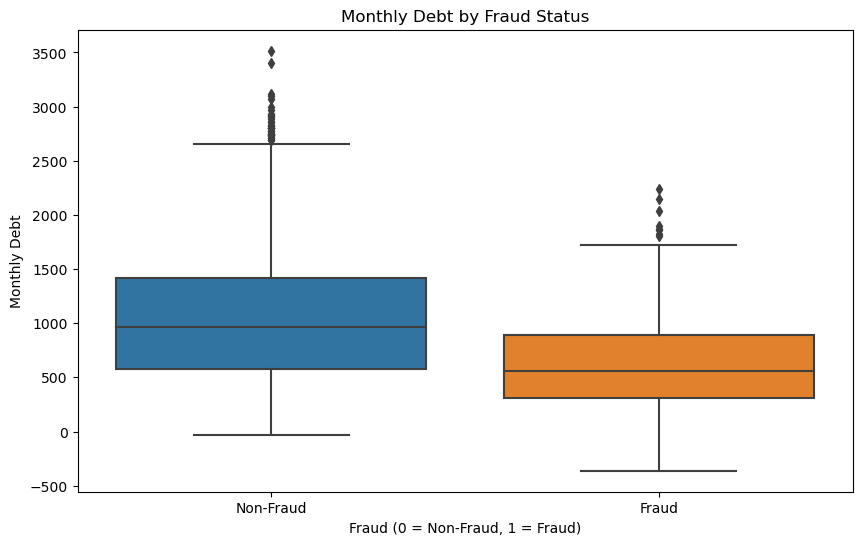

In [8]:
# Analyze monthly debt by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraud', y='monthly_debt', data=data)
plt.title('Monthly Debt by Fraud Status')
plt.xlabel('Fraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Monthly Debt')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()

In [9]:
# Step 1.2: Preprocessing Steps and Feature Engineering
# Example of creating new features
data['loan_to_income_ratio'] = data['loan_amount'] / data['income']
data['monthly_debt_to_income_ratio'] = data['monthly_debt'] / (data['income'] / 12)

# One-hot encode categorical features
data = pd.get_dummies(data, columns=['employment_status', 'loan_purpose', 'residence_type'], drop_first=True)

# Check the updated dataset with new encoded columns
data.head()


,credit_score,income,loan_amount,loan_term,property_value,down_payment,monthly_debt,fraud,loan_to_income_ratio,monthly_debt_to_income_ratio,employment_status_self-employed,employment_status_unemployed,loan_purpose_purchase,loan_purpose_refinance,residence_type_primary,residence_type_secondary
0,816,57631.52,172141.74,10,265196.65,47113.37,1799.959653,0,2.986937,0.374787,0,0,1,0,1,0
1,757,44960.52,219495.84,20,336570.38,42114.43,446.127538,0,4.881968,0.119072,0,0,0,1,0,1
2,847,32194.92,198853.20,30,253821.41,19185.19,993.858253,0,6.176540,0.370440,0,1,0,0,1,0
3,651,61168.91,224470.32,10,198034.10,25108.19,630.112492,0,3.669680,0.123614,1,0,0,0,0,0
4,657,41055.58,172539.75,30,286421.59,17573.86,469.844642,0,4.202590,0.137329,0,1,0,0,1,0


In [10]:
# 1.2.2 Handle Missing Values

# Introduce missing values randomly in the dataset (for demonstration)
# data.loc[np.random.choice(data.index, size=500), 'income'] = np.nan  # Introduce missing values in 'income'
# data.loc[np.random.choice(data.index, size=300), 'credit_score'] = np.nan  # Introduce missing values in 'credit_score'


# Check for any remaining missing values
# print(data.isnull().sum())

# Fill missing values with mean or median (for numerical columns)
# data['income'].fillna(data['income'].mean(), inplace=True)
# data['credit_score'].fillna(data['credit_score'].median(), inplace=True)

# Check for any remaining missing values
# print(data.isnull().sum())

In [11]:
# 1.2.3 Scaling Numerical Features


# Define the numerical columns to scale
numerical_cols = ['credit_score', 'income', 'loan_amount', 'property_value', 'down_payment','loan_to_income_ratio','monthly_debt_to_income_ratio']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display the scaled dataset
data.head()


,credit_score,income,loan_amount,loan_term,property_value,down_payment,monthly_debt,fraud,loan_to_income_ratio,monthly_debt_to_income_ratio,employment_status_self-employed,employment_status_unemployed,loan_purpose_purchase,loan_purpose_refinance,residence_type_primary,residence_type_secondary
0,1.148227,0.244937,-0.883865,10,-0.361065,1.497815,1799.959653,0,-0.085747,1.414440,0,0,1,0,1,0
1,0.490946,-0.530744,0.611737,20,0.675924,1.079162,446.127538,0,0.048436,-1.064448,0,0,0,1,0,1
2,1.493579,-1.312216,-0.040227,30,-0.526336,-0.841120,993.858253,0,0.140102,1.372309,0,1,0,0,1,0
3,-0.689933,0.461486,0.768848,10,-1.336870,-0.345080,630.112492,0,-0.037404,-1.020414,1,0,0,0,0,0
4,-0.623091,-0.769792,-0.871295,30,-0.052688,-0.976066,469.844642,0,0.000331,-0.887460,0,1,0,0,1,0


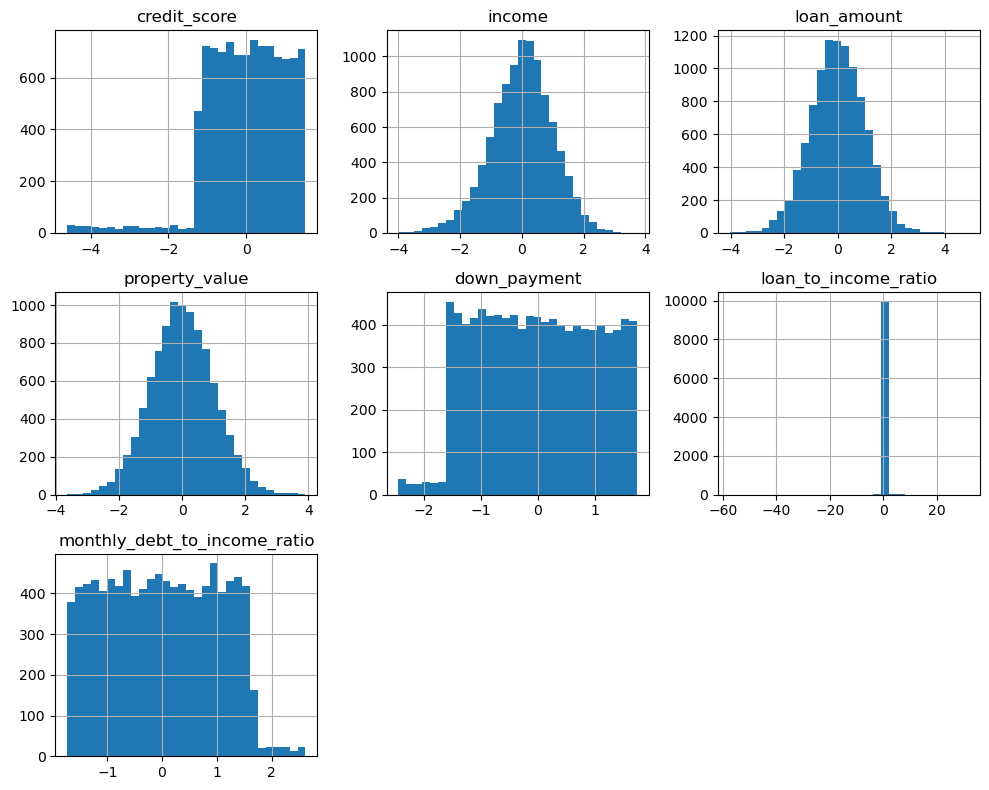

In [12]:
# 1.3.1 Plot distribution of numerical features
data[numerical_cols].hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()



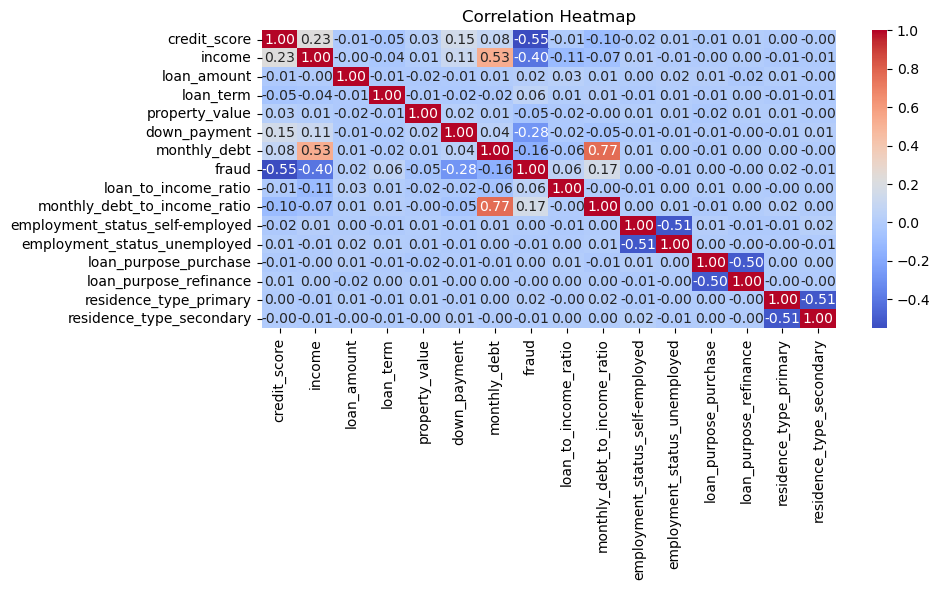

In [13]:
# 1.3.2 Correlation Heatmap

# Plot a heatmap of the correlations between numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [15]:
# Step 2.1: Split the Data into Training and Testing Sets

# Separate the features (X) and the target (y)
X = data.drop('fraud', axis=1)
y = data['fraud']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)


Training data size: (8000, 15)
Testing data size: (2000, 15)


In [16]:
# Step 2.2: Train the XGBoost Model

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)


In [17]:
# Step 2.3: Evaluate the Model

# Print precision, recall, and F1-score
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Precision: 0.9263157894736842
Recall: 0.88
F1-score: 0.9025641025641025

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1900
           1       0.93      0.88      0.90       100

    accuracy                           0.99      2000
   macro avg       0.96      0.94      0.95      2000
weighted avg       0.99      0.99      0.99      2000



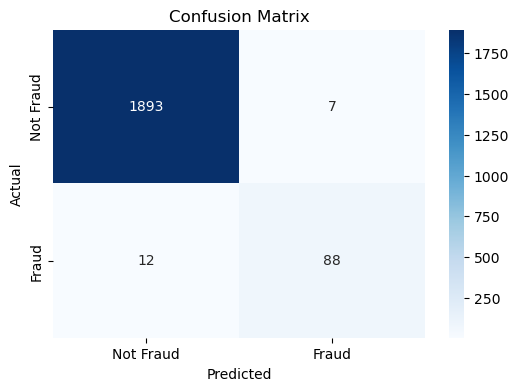

In [18]:
# Confusion Matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()


In [19]:
# Step 3: Model Improvement
# Step 3.1: Handle Class Imbalance Using SMOTE


# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to oversample the minority class (fraud cases)
smote = SMOTE(sampling_strategy=1)  # Set 1 to balance fraud and non-fraud cases
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [20]:
# Step 3.2: Train a Gradient Boosting Model (XGBoost or LightGBM) with Class Weights

# Define the class ratio (majority to minority class ratio)
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Train the XGBoost model with class weights
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Train LightGBM with class weights
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_train_resampled, y_train_resampled)


[LightGBM] [Info] Number of positive: 6650, number of negative: 6650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2067
[LightGBM] [Info] Number of data points in the train set: 13300, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [21]:
# Step 3.3: Adjust the Decision Threshold to Prioritize Recall

# Predict probabilities instead of labels
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]

# Set a custom threshold, let's say 0.2 to improve recall
threshold = 0.2
y_pred_custom = (y_pred_probs >= threshold).astype(int)


Confusion Matrix:
 [[2825   25]
 [  17  133]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2850
           1       0.84      0.89      0.86       150

    accuracy                           0.99      3000
   macro avg       0.92      0.94      0.93      3000
weighted avg       0.99      0.99      0.99      3000

Precision: 0.8417721518987342
Recall: 0.8866666666666667
F1-score: 0.8636363636363636


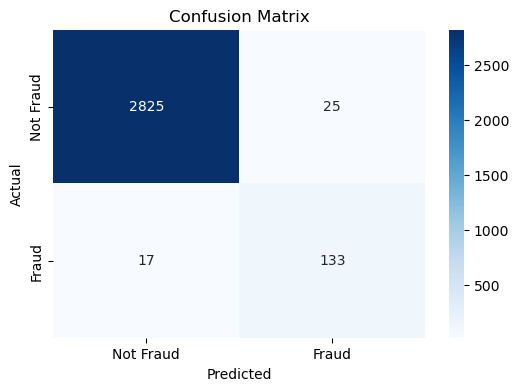

In [22]:
# Step 4: Evaluate Model Performance

# Classification report after adjusting the threshold
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_custom))

# Precision, Recall, and F1-score
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Confusion Matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_custom)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()



In [23]:
# Step 3.5: Tune Hyperparameters with GridSearchCV

from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'scale_pos_weight': [1, scale_pos_weight]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=5, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters found by Grid Search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Re-train the model with the best parameters
best_xgb_model = XGBClassifier(**best_params, random_state=42)
best_xgb_model.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [24]:
# Step 3.6: Use Cross-Validation for Robustness

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5)

# Loop through the splits
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets for this fold
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]  # Use .iloc for row selection
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]  # Use .iloc for row selection
    
    # Apply SMOTE within each fold to handle class imbalance
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)
    
    # Train the model in each fold using the resampled data
    best_xgb_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict probabilities for the test set in this fold
    y_pred_probs_cv = best_xgb_model.predict_proba(X_test_cv)[:, 1]
    
    # Convert probabilities to binary predictions using the defined threshold
    y_pred_cv = (y_pred_probs_cv >= threshold).astype(int)
    
    # Print the confusion matrix for the current fold
    print("Fold Confusion Matrix:\n", confusion_matrix(y_test_cv, y_pred_cv))
    
    # Print the classification report for the current fold
    print("Fold Classification Report:\n", classification_report(y_test_cv, y_pred_cv))


Fold Confusion Matrix:
 [[1870   30]
 [   2   98]]
Fold Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1900
           1       0.77      0.98      0.86       100

    accuracy                           0.98      2000
   macro avg       0.88      0.98      0.93      2000
weighted avg       0.99      0.98      0.98      2000

Fold Confusion Matrix:
 [[1887   13]
 [   9   91]]
Fold Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1900
           1       0.88      0.91      0.89       100

    accuracy                           0.99      2000
   macro avg       0.94      0.95      0.94      2000
weighted avg       0.99      0.99      0.99      2000

Fold Confusion Matrix:
 [[1870   30]
 [   3   97]]
Fold Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      19